# CS 1656 – Introduction to Data Science (Fall 2020) 

## Instructor: Alexandros Labrinidis /Teaching Assistant: Evangelos Karageorgos

## Term Project 

**Released: October 21, 2020**

**Due: December 2, 2020**

### Goal
The goal of this project is to expose you with a real data science problem, looking at the end-to-end pipeline. 

### What to do 
You are asked to write a Python Jupyter notebook, called `pgh_bike.ipynb` that will:
* [Task 1] access historical bike rental data for 2019 from HealthyRidePGH and summarize the rental data  
* [Task 2] create graphs to show the popularity of the different rental stations, given filter conditions  
* [Task 3] create graphs to show the rebalancing issue  
* [Task 4] cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.  

**Your program should not take more than 15 minutes to run**

### Jupyter Notebook Rules
This skeleton is provided for you to complete the project. Please add your code in the code cells below each Task. Feel free to add cells as needed. Do not remove existing cells.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn.cluster import DBSCAN

# Feel free to add here any other libraries as specified in the project description

For the sake of interactive display in Jupyter, we will enable matplotlib inline.

In [3]:
%matplotlib inline

### [Task 0] Warming Up
Task 0 is for testing. It is used to ensure that this Jupyter Notebook skeleton works on both your machines and our machine. Please run the following code to see if you can see a line plot. The line plot is the basic plot that we have seen in Recitation2. 

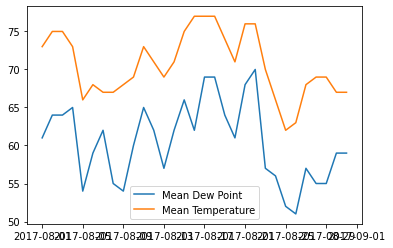

In [4]:
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
df = pd.read_csv('KPIT_Aug17.csv', sep=',', engine='python', parse_dates=['EST'])
p1 = plt.plot(df['EST'],df['MeanDew PointF'])
p2 = plt.plot(df['EST'],df['Mean TemperatureF'])
plt.legend([p1[0],p2[0]], ['Mean Dew Point', 'Mean Temperature'])

plt.show()

--- 
Add your code below this line

---
### Task 1

In this task you will need to access historical bike rental data for 2019 from HealthyRidePGH and summarize the rental data.

In [5]:
files = ['HealthyRideRentals2019-Q1.csv', 'HealthyRideRentals2019-Q2.csv', 'HealthyRideRentals2019-Q3.csv']
df = pd.concat([pd.read_csv(f) for f in files])
df.head()

,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype
0,63918850,1/5/19 16:02,1/5/19 17:35,70585,5624,1025.0,Penn Ave & N Fairmount St,1025.0,Penn Ave & N Fairmount St,Customer
1,63920576,1/5/19 21:18,1/5/19 21:22,70585,232,1025.0,Penn Ave & N Fairmount St,1026.0,Penn Ave & S Whitfield St,Customer
2,64076019,1/15/19 14:09,1/15/19 14:20,70147,705,1028.0,Penn Ave & Putnam St (Bakery Square),49371.0,E Liberty Blvd & Larimer Ave,Customer
3,64281721,1/28/19 16:34,1/28/19 17:27,70658,3201,1041.0,Fifth Ave & S Bouquet St,1066.0,N Homewood Ave & Finance St (Homewood Station),Subscriber
4,64316376,1/30/19 17:52,1/30/19 19:05,70206,4361,1047.0,S 22nd St & E Carson St,49771.0,Fifth Ave & Jumonville St,Customer


In [6]:
# Extract everything in ways that make it easy to do operations

df_task1 = df.copy()
df_task1['Startdate'], df_task1['Stopdate'] = [r.split()[0] for r in df_task1['Starttime']], [r.split()[0] for r in df_task1['Stoptime']]
df_task1['Startmonth'], df_task1['Stopmonth'] = [int(r.split('/')[0]) for r in df_task1['Startdate']], [int(r.split('/')[0]) for r in df_task1['Stopdate']]
df_task1['Startday'], df_task1['Stopday'] = [int(r.split('/')[1]) for r in df_task1['Startdate']], [int(r.split('/')[1]) for r in df_task1['Stopdate']]
df_task1['Starthour'], df_task1['Stophour'] = [int(r.split()[1].split(':')[0]) for r in df_task1['Starttime']], [int(r.split()[1].split(':')[0]) for r in df_task1['Stoptime']]
df_task1['count'] = 1

df_from_hour = df_task1[['Startmonth', 'Startday', 'Starthour', 'From station id', 'count']]
df_to_hour = df_task1[['Stopmonth', 'Stopday', 'Stophour', 'To station id', 'count']]
df_from_day = df_task1[['Startmonth', 'Startday', 'From station id', 'count']]
df_to_day = df_task1[['Stopmonth', 'Stopday', 'To station id', 'count']]
df_from_month = df_task1[['Startmonth', 'From station id', 'count']]
df_to_month = df_task1[['Stopmonth', 'To station id', 'count']]

df_from_hour.columns = ['month', 'day', 'hour', 'stationID', 'fromCNT']
df_to_hour.columns = ['month', 'day', 'hour', 'stationID', 'toCNT']
df_from_day.columns = ['month', 'day', 'stationID', 'fromCNT']
df_to_day.columns = ['month', 'day', 'stationID', 'toCNT']
df_from_month.columns = ['month', 'stationID', 'fromCNT']
df_to_month.columns = ['month', 'stationID', 'toCNT']

In [7]:
# Group by the appropriate attributes and get the count for that grouping

df_from_hour = df_from_hour.groupby(['month', 'day', 'hour', 'stationID'], as_index=False).sum()
df_to_hour = df_to_hour.groupby(['month', 'day', 'hour', 'stationID'], as_index=False).sum()
df_from_day = df_from_day.groupby(['month', 'day', 'stationID'], as_index=False).sum()
df_to_day = df_to_day.groupby(['month', 'day', 'stationID'], as_index=False).sum()
df_from_month = df_from_month.groupby(['month', 'stationID'], as_index=False).sum()
df_to_month = df_to_month.groupby(['month', 'stationID'], as_index=False).sum()

In [8]:
# Do full outer join on the two DFs to combine the counts

df_hour = pd.merge(df_from_hour, df_to_hour, on=['month', 'day', 'hour', 'stationID'], how='outer')
df_hour['fromCNT'], df_hour['toCNT'] = df_hour['fromCNT'].fillna(0), df_hour['toCNT'].fillna(0)

df_day = pd.merge(df_from_day, df_to_day, on=['month', 'day', 'stationID'], how='outer')
df_day['fromCNT'], df_day['toCNT'] = df_day['fromCNT'].fillna(0), df_day['toCNT'].fillna(0)

df_month = pd.merge(df_from_month, df_to_month, on=['month', 'stationID'], how='outer')
df_month['fromCNT'], df_month['toCNT'] = df_month['fromCNT'].fillna(0), df_month['toCNT'].fillna(0)

In [9]:
# Compute rebalCNT approximation
# Using absolute value to make the plots nicer later on

df_hour['rebalCNT'] = abs(df_hour['fromCNT'] - df_hour['toCNT'])
df_day['rebalCNT'] = abs(df_day['fromCNT'] - df_day['toCNT'])
df_month['rebalCNT'] = abs(df_month['fromCNT'] - df_month['toCNT'])

### Task 1.1
Print the first 20 rows of the data structure you used to store the above data (i.e, daily breakdown).

In [10]:
df_day.head(20)

,month,day,stationID,fromCNT,toCNT,rebalCNT
0,1,1,1000.0,4.0,4.0,0.0
1,1,1,1002.0,1.0,1.0,0.0
2,1,1,1009.0,1.0,0.0,1.0
3,1,1,1010.0,1.0,1.0,0.0
4,1,1,1012.0,4.0,3.0,1.0
5,1,1,1021.0,2.0,1.0,1.0
6,1,1,1023.0,1.0,1.0,0.0
7,1,1,1024.0,2.0,1.0,1.0
8,1,1,1028.0,1.0,1.0,0.0
9,1,1,1029.0,2.0,2.0,0.0


### Task 1.2
Print the first 20 rows of the data structure you used to store the above data (i.e., monthly breakdown).

In [11]:
# Can also get this by aggregating the df_day data but I used separate data structures to make it easier to keep track of
df_month.head(20)

,month,stationID,fromCNT,toCNT,rebalCNT
0,1,1000.0,35.0,43.0,8.0
1,1,1001.0,59.0,82.0,23.0
2,1,1002.0,36.0,27.0,9.0
3,1,1003.0,11.0,12.0,1.0
4,1,1004.0,32.0,31.0,1.0
5,1,1005.0,17.0,13.0,4.0
6,1,1006.0,39.0,27.0,12.0
7,1,1007.0,6.0,2.0,4.0
8,1,1008.0,5.0,2.0,3.0
9,1,1009.0,42.0,44.0,2.0


---
### Task 2

In this task you will need to create graphs to show the popularity of the different rental stations, given filter conditions.

In [12]:
# FILTER VARIABLES -- feel free to edit the values, but the names of the variables must remain 
#                     as they are and should be used by your code accordingly from this point on

filter_month = 4
filter_stationID = 1046

### Task 2.1
Show a bar chart for the 25 most popular bikestations when considering the number of fromCNT per station (for filter_month). Y axis should be the fromCNT per station, X axis should be the stationID. The first stationID corresponds to the most popular station.

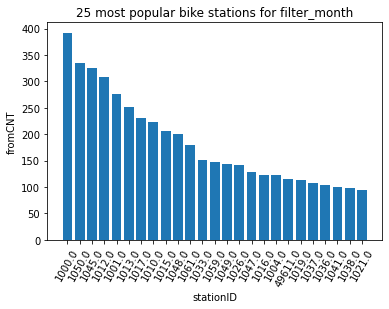

In [13]:
df_task_2_1 = df_month[df_month['month']==filter_month]
df_task_2_1 = df_task_2_1.sort_values(by='fromCNT', ascending=False).head(25)

plt.bar(range(len(df_task_2_1['stationID'])), df_task_2_1['fromCNT'], align='center')
plt.xticks(range(len(df_task_2_1['stationID'])), df_task_2_1['stationID'],\
               rotation=60, fontsize=10)
plt.xlabel('stationID')
plt.ylabel('fromCNT')
plt.title('25 most popular bike stations for filter_month')
plt.show()

### Task 2.2
For the filter_month and for the filter_stationID show a graph that shows the distribution of bike rentals throughout the month, for that station only. Y axis should be the fromCNT for that stationID for that day, X axis would be the different days in that month (i.e., 1 - 30 for April).

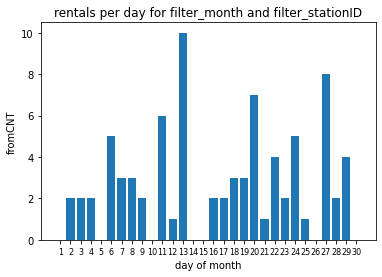

In [14]:
df_task_2_2 = df_day[(df_day['month']==filter_month) & (df_day['stationID']==filter_stationID)]
df_task_2_2 = df_task_2_2.sort_values(by='day')

plt.bar(range(len(df_task_2_2['day'])), df_task_2_2['fromCNT'], align='center')
plt.xticks(range(len(df_task_2_2['day'])), df_task_2_2['day'], fontsize=8)
plt.xlabel('day of month')
plt.ylabel('fromCNT')
plt.title('rentals per day for filter_month and filter_stationID')
plt.show()

### Task 2.3
For the filter_month (e.g., April) show a graph that shows the distribution of bike rentals throughout the day, for all stations. Y axis should be the fromCNT for all stations in the filter_month, X axis would be the different hours in a day (i.e., 0 - 23).

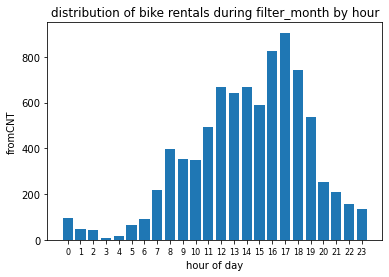

In [15]:
df_task_2_3 = df_hour[df_hour['month']==filter_month][['hour', 'fromCNT']]
df_task_2_3 = df_task_2_3.groupby('hour', as_index=False).sum()

plt.bar(range(len(df_task_2_3['hour'])), df_task_2_3['fromCNT'], align='center')
plt.xticks(range(len(df_task_2_3['hour'])), df_task_2_3['hour'], fontsize=8)
plt.xlabel('hour of day')
plt.ylabel('fromCNT')
plt.title('distribution of bike rentals during filter_month by hour')
plt.show()

### Task 2.4
Update your data structure to compute the total number of rentals each bike had for each day (regardless of station). In other words, figure out how many times a bike was listed in the input data, for each different date. For the filter_month, show a graph that shows the 25 most popular bikes. Y axis should be the number of times a bike was rented, X axis should be the bikeID. The first bikeID corresponds to the most popular station.

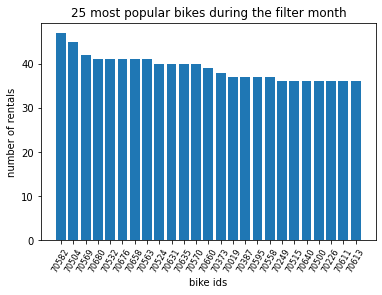

In [16]:
df_task_2_4 = df_task1[df_task1['Startmonth']==filter_month][['Startmonth', 'Startday', 'Bikeid', 'count']]
df_task_2_4.columns = ['month', 'day', 'bikeid', 'rentalcount']

# Get the rental count for each bike, for each day (regardless of station)
df_task_2_4 = df_task_2_4.groupby(['month', 'day', 'bikeid'], as_index=False).sum()

# Get the 25 most popular bikes for the entire month
df_task_2_4 = df_task_2_4[['month', 'bikeid', 'rentalcount']].groupby(['month', 'bikeid'], as_index=False).sum() \
    .sort_values(by='rentalcount', ascending=False).head(25)

# Graph the 25 most popular bikes
plt.bar(range(len(df_task_2_4['bikeid'])), df_task_2_4['rentalcount'], align='center')
plt.xticks(range(len(df_task_2_4['bikeid'])), df_task_2_4['bikeid'], rotation=60, fontsize=8)
plt.xlabel('bike ids')
plt.ylabel('number of rentals')
plt.title('25 most popular bikes during the filter month')
plt.show()

---
### Task 3

In this task you will create graphs to show the rebalancing issue.

### Task 3.1
Show a bar chart for the 25 most popular bikestations when considering the number of rebalCNT per station (for filter_month). Y axis should be the rebalCNT per station, X axis should be the stationID. The first stationID corresponds to the most demanding station in terms of rebalancing.

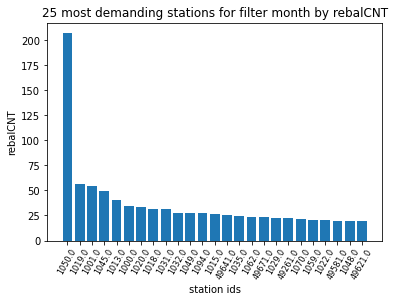

In [17]:
df_task_3_1 = df_month[df_month['month']==filter_month][['month', 'stationID', 'rebalCNT']] \
    .sort_values(by='rebalCNT', ascending=False).head(25)

plt.bar(range(len(df_task_3_1['stationID'])), df_task_3_1['rebalCNT'], align='center')
plt.xticks(range(len(df_task_3_1['stationID'])), df_task_3_1['stationID'], rotation=60, fontsize=8)
plt.xlabel('station ids')
plt.ylabel('rebalCNT')
plt.title('25 most demanding stations for filter month by rebalCNT')
plt.show()

# Task 3.2
For the filter_month and for the filter_stationID show a graph that shows the distribution of bike rebalancing throughout the month, for that station only. Y axis should be the rebalCNT for that stationID for that day, X axis would be the different days in that month (i.e., 1 - 30 for April).

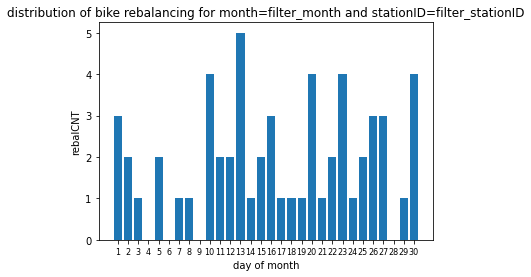

In [18]:
df_task_3_2 = df_day[(df_day['month']==filter_month) & (df_day['stationID']==filter_stationID)] \
    [['month', 'day', 'stationID', 'rebalCNT']].sort_values(by='day')

plt.bar(range(len(df_task_3_2['day'])), df_task_3_2['rebalCNT'], align='center')
plt.xticks(range(len(df_task_3_2['day'])), df_task_3_2['day'], fontsize=8)
plt.xlabel('day of month')
plt.ylabel('rebalCNT')
plt.title('distribution of bike rebalancing for month=filter_month and stationID=filter_stationID')
plt.show()

---
### Task 4

In this task you will cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.

### Task 4.1
You should perform clustering on the above 6-dimensional space using K-means (with at least 3 different values for K) and DBSCAN (with at least three different value combinations for min_samples and eps) https://scikit-learn.org/stable/modules/clustering.html#clustering.

In [19]:
# Extract the data based on the month
df_month_7 = df_month[df_month['month']==7][['stationID', 'fromCNT', 'rebalCNT']]
df_month_8 = df_month[df_month['month']==8][['stationID', 'fromCNT', 'rebalCNT']]
df_month_9 = df_month[df_month['month']==9][['stationID', 'fromCNT', 'rebalCNT']]

# Rename the columns for merging
df_month_7.columns = ['stationID', 'fromCNT7', 'rebalCNT7']
df_month_8.columns = ['stationID', 'fromCNT8', 'rebalCNT8']
df_month_9.columns = ['stationID', 'fromCNT9', 'rebalCNT9']

# Do full outer join to merge all of the dfs into one
df_task_4_1 = pd.merge(df_month_7, df_month_8, on='stationID', how='outer')
df_task_4_1 = pd.merge(df_task_4_1, df_month_9, on='stationID', how='outer')

# Remove NaNs
df_task_4_1['fromCNT7'], df_task_4_1['fromCNT8'], df_task_4_1['fromCNT9'] = \
    df_task_4_1['fromCNT7'].fillna(0), df_task_4_1['fromCNT8'].fillna(0), df_task_4_1['fromCNT9'].fillna(0)
df_task_4_1['rebalCNT7'], df_task_4_1['rebalCNT8'], df_task_4_1['rebalCNT9'] = \
    df_task_4_1['rebalCNT7'].fillna(0), df_task_4_1['rebalCNT8'].fillna(0), df_task_4_1['rebalCNT9'].fillna(0)

cluster_df = df_task_4_1[['fromCNT7', 'fromCNT8', 'fromCNT9', 'rebalCNT7', 'rebalCNT8', 'rebalCNT9']]

# It might be better to remove stationID 666 from the dataset before performing any of these operations. 
# I looked at it in the .csv file since it has weird fromCNT/rebalCNT numbers relative to the other stations 
# and its name is "Sara's Car". Sara is the name of the Director of Operations at Healthy Ride, so it's possible 
# that this is her rebalancing the bikes or something similar? I didn't remove it for these purposes because I don't 
# know for sure that the data can be ruled out, and it probably doesn't have a noticeable impact on anything, 
# but it is certainly worth considering.

In [37]:
k_means_4 = cluster.KMeans(n_clusters=4, init = 'k-means++',\
                         random_state=5000)
k_means_5 = cluster.KMeans(n_clusters=5, init = 'k-means++',\
                         random_state=5000)
k_means_6 = cluster.KMeans(n_clusters=6, init = 'k-means++',\
                         random_state=5000)

k_means_4.fit(cluster_df[['fromCNT7', 'fromCNT8', 'fromCNT9', 'rebalCNT7', 'rebalCNT8', 'rebalCNT9']])
k_means_5.fit(cluster_df[['fromCNT7', 'fromCNT8', 'fromCNT9', 'rebalCNT7', 'rebalCNT8', 'rebalCNT9']])
k_means_6.fit(cluster_df[['fromCNT7', 'fromCNT8', 'fromCNT9', 'rebalCNT7', 'rebalCNT8', 'rebalCNT9']])

db_1 = DBSCAN(eps=40, min_samples=3).fit(cluster_df)
db_2 = DBSCAN(eps=30, min_samples=3).fit(cluster_df)
db_3 = DBSCAN(eps=45, min_samples=5).fit(cluster_df)

### Task 4.2
You should generate one bar chart per algorithm option (i.e., 6 different charts) showing the distribution of the number of stations per cluster. Y axis should be the number of stations in that cluster, X axis would be the clusterID. The first clusterID corresponds to the biggest cluster. Make sure each graph is properly labeled with the algorithm name and the parameters used.



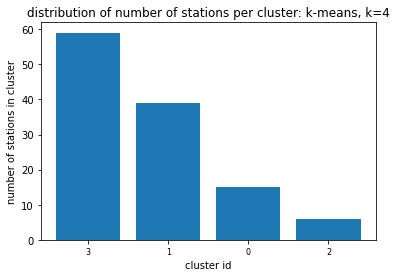

In [39]:
hist_4 = np.histogram(k_means_4.labels_, bins=[0, 1, 2, 3, 4])
bins = [0, 1, 2, 3]

df_4 = pd.DataFrame(list(zip(bins, hist_4[0])), columns=['clusterID', 'frequency']) \
    .sort_values(by='frequency', ascending=False)

plt.bar(range(len(df_4['clusterID'])), df_4['frequency'], align='center')
plt.xticks(range(len(df_4['clusterID'])), df_4['clusterID'], fontsize=8)
plt.xlabel('cluster id')
plt.ylabel('number of stations in cluster')
plt.title('distribution of number of stations per cluster: k-means, k=4')
plt.show()

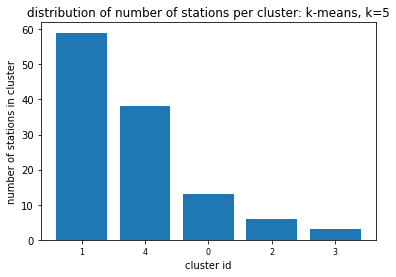

In [40]:
hist_5 = np.histogram(k_means_5.labels_, bins=[0, 1, 2, 3, 4, 5])
bins = [0, 1, 2, 3, 4]

df_5 = pd.DataFrame(list(zip(bins, hist_5[0])), columns=['clusterID', 'frequency']) \
    .sort_values(by='frequency', ascending=False)

plt.bar(range(len(df_5['clusterID'])), df_5['frequency'], align='center')
plt.xticks(range(len(df_5['clusterID'])), df_5['clusterID'], fontsize=8)
plt.xlabel('cluster id')
plt.ylabel('number of stations in cluster')
plt.title('distribution of number of stations per cluster: k-means, k=5')
plt.show()

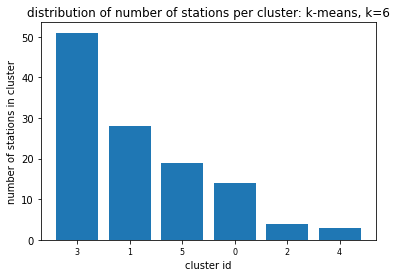

In [41]:
hist_6 = np.histogram(k_means_6.labels_, bins=[0, 1, 2, 3, 4, 5, 6])
bins = [0, 1, 2, 3, 4, 5]

df_6 = pd.DataFrame(list(zip(bins, hist_6[0])), columns=['clusterID', 'frequency']) \
    .sort_values(by='frequency', ascending=False)

plt.bar(range(len(df_6['clusterID'])), df_6['frequency'], align='center')
plt.xticks(range(len(df_6['clusterID'])), df_6['clusterID'], fontsize=8)
plt.xlabel('cluster id')
plt.ylabel('number of stations in cluster')
plt.title('distribution of number of stations per cluster: k-means, k=6')
plt.show()

In [30]:
# I figured that the noise shouldn't be included as a 'cluster' in the technical sense, but I left the option to view it
# by changing this variable to true, because it could be useful to see just how many points are classified as noise.

include_noise_as_cluster = False

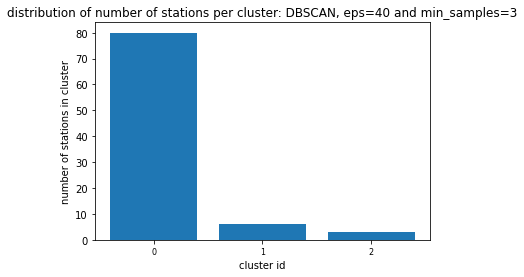

In [25]:
ids = []
bins = []
for num in db_1.labels_:
    if num not in bins and (include_noise_as_cluster or num != -1):
        ids.append(num)
        bins.append(num)
        
ids.sort()
bins.sort()
bins.append(bins[-1] + 1)

hist_db_1 = np.histogram(db_1.labels_, bins=bins)
df_db_1 = pd.DataFrame(list(zip(ids, hist_db_1[0])), columns=['clusterID', 'frequency']) \
    .sort_values(by='frequency', ascending=False)

plt.bar(range(len(df_db_1['clusterID'])), df_db_1['frequency'], align='center')
plt.xticks(range(len(df_db_1['clusterID'])), df_db_1['clusterID'], fontsize=8)

if include_noise_as_cluster:  
    plt.xlabel('cluster id (-1 is noise)')
else:
    plt.xlabel('cluster id')
    
plt.ylabel('number of stations in cluster')
plt.title('distribution of number of stations per cluster: DBSCAN, eps=40 and min_samples=3')
plt.show()

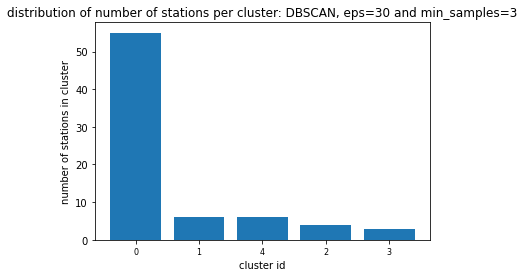

In [26]:
ids = []
bins = []
for num in db_2.labels_:
    if num not in bins and (include_noise_as_cluster or num != -1):
        ids.append(num)
        bins.append(num)
        
ids.sort()
bins.sort()
bins.append(bins[-1] + 1)

hist_db_2 = np.histogram(db_2.labels_, bins=bins)
df_db_2 = pd.DataFrame(list(zip(ids, hist_db_2[0])), columns=['clusterID', 'frequency']) \
    .sort_values(by='frequency', ascending=False)

plt.bar(range(len(df_db_2['clusterID'])), df_db_2['frequency'], align='center')
plt.xticks(range(len(df_db_2['clusterID'])), df_db_2['clusterID'], fontsize=8)

if include_noise_as_cluster:  
    plt.xlabel('cluster id (-1 is noise)')
else:
    plt.xlabel('cluster id')
    
plt.ylabel('number of stations in cluster')
plt.title('distribution of number of stations per cluster: DBSCAN, eps=30 and min_samples=3')
plt.show()

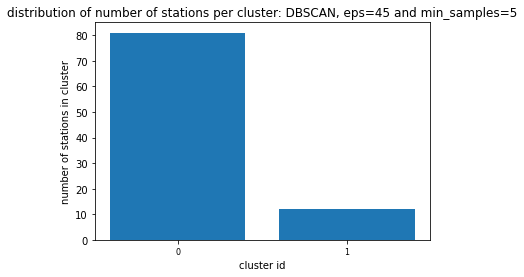

In [27]:
ids = []
bins = []
for num in db_3.labels_:
    if num not in bins and (include_noise_as_cluster or num != -1):
        ids.append(num)
        bins.append(num)
        
ids.sort()
bins.sort()
bins.append(bins[-1] + 1)

hist_db_3 = np.histogram(db_3.labels_, bins=bins)
df_db_3 = pd.DataFrame(list(zip(ids, hist_db_3[0])), columns=['clusterID', 'frequency']) \
    .sort_values(by='frequency', ascending=False)

plt.bar(range(len(df_db_3['clusterID'])), df_db_3['frequency'], align='center')
plt.xticks(range(len(df_db_3['clusterID'])), df_db_3['clusterID'], fontsize=8)

if include_noise_as_cluster:  
    plt.xlabel('cluster id (-1 is noise)')
else:
    plt.xlabel('cluster id')
    
plt.ylabel('number of stations in cluster')
plt.title('distribution of number of stations per cluster: DBSCAN, eps=45 and min_samples=5')
plt.show()

### Task 4.3
You should provide a brief explanation about your choice of K. This should be in the form of plain text inside the Jupyter notebook, under the Task 4.3 heading. You should also mention (a) what is the best value of K that you found and (b) what is the best algorithm out of the two that you tried. For the second question, it is possible the results will be inconclusive.

**Answer:** I selected the k-values of 4, 5, and 6 somewhat randomly. I did some research into how to find the optimal value of k, and I found some articles about the Elbow Method (which we may have talked about in class, but I don't remember). I found a program ([source](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)) to find the distortion and inertias of each k-value from 0 to 10 and ran it here with the clustering data (I had to import from scipy down here, but I hope that's not an issue since this was just for extracurricular research). The Elbow Method says that the optimal value of k is the value at which the distortion and inertia begin to decrease linearly, which appears to be k=4.

It is difficult to assess which algorithm is better for clustering the data. I am leaning towards DBSCAN being more effective for this dataset, however, because the clusters created by every iteration of K-means seem to be imbalanced, meaning that there is a relatively dense concentration of points making up one cluster, and a wide range of noise that is making up other clusters. DBSCAN seems to capture this behavior well, as can be seen in the graphs. This imbalance is good to see in DBSCAN, because that is generally how the algorithm is supposed to work - the results it provides are supposed to feel more intuitive than those provided by K-means.

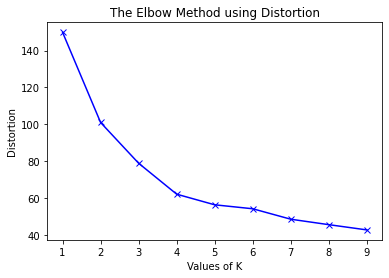

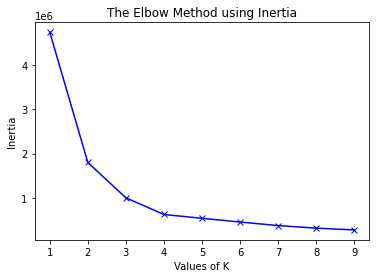

In [28]:
from scipy.spatial.distance import cdist

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = cluster.KMeans(n_clusters=k).fit(cluster_df) 
    kmeanModel.fit(cluster_df)     
      
    distortions.append(sum(np.min(cdist(cluster_df, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / cluster_df.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(cluster_df, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / cluster_df.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 